### Importing Dependencies


In [ ]:
!pip install gekko

In [ ]:
!pip install -U pandas-profiling

In [ ]:
import pandas as pd
import itertools
from collections import defaultdict
from itertools import permutations,combinations
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
from gekko import GEKKO
from pandas_profiling import ProfileReport
from PIL import Image
import requests

---

# Data

In [5]:
# Importing dataset 
data=pd.read_csv("../data/attribution_data.csv")
data=pd.DataFrame(data)
data

cookie                  time interaction  \
0       00000FkCnDfDDf0iC97iC703B  2018-07-03T13:02:11Z  impression   
1       00000FkCnDfDDf0iC97iC703B  2018-07-17T19:15:07Z  impression   
2       00000FkCnDfDDf0iC97iC703B  2018-07-24T15:51:46Z  impression   
3       00000FkCnDfDDf0iC97iC703B  2018-07-29T07:44:51Z  impression   
4       0000nACkD9nFkBBDECD3ki00E  2018-07-03T09:44:57Z  impression   
...                           ...                   ...         ...   
586732  ooooEiB0CCoEf9fiiC90Dfhfk  2018-07-12T23:50:45Z  impression   
586733  ooooEiB0CCoEf9fiiC90Dfhfk  2018-07-12T23:50:54Z  impression   
586734  ooooiBh70D3k3BfAhDFfii9h7  2018-07-03T12:57:25Z  impression   
586735  ooooiBh70D3k3BfAhDFfii9h7  2018-07-19T08:17:59Z  impression   
586736  ooooohAFofEnonEikhAi3fF9o  2018-07-14T17:17:12Z  impression   

        conversion  conversion_value         channel  
0                0               0.0       Instagram  
1                0               0.0  Online Display  
2                0               0.0  Online Display  
3                0               0.0  Online Display  
4                0               0.0     Paid Search  
...            ...               ...             ...  
586732           0               0.0  Online Display  
586733           0               0.0  Online Display  
586734           0               0.0     Paid Search  
586735           0               0.0    Online Video  
586736           0               0.0     Paid Search  

[586737 rows x 6 columns]

---

# Exploratory Data Analysis

In [33]:
# Creating exploratory data analysis report using pandas profiling python module

profile = ProfileReport(data, title='Attribution Data Report', explorative=True) 

In [ ]:
# Displaying the report

profile.to_widgets()

In [ ]:
profile1 = ProfileReport(data, title='Attribution Data Report', explorative=True)
profile1.to_file("Report.html")               # An html report is being generated'

---

# I. Single-Touch Attribution Models


*  Single-touch attribution models assign 100% of conversion  credit to one marketing channel disregarding any number of channels visited by an user.

*   This a very naive and easy approach because of their low level of complexity. 

*   These models should be used when the number of channels for a particular campaign is 5 or less.(Preferrably Last-Touch Attribution Model)








## 1. Last-Touch Attribution Model



*   Last-touch attribution assigns 100% of the credit to the last marketing touchpoint.

*   The argument behind this approach is that the last touch is all that matters because it resulted in the actual conversion, but in reality it doesn’t tell the whole story. Your customers are likely engaging with your brand across multiple touchpoints on various channels before they convert.



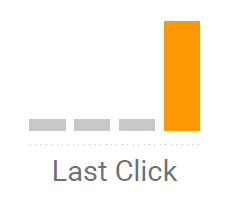

In [36]:
# Here's an image for a better understanding of last-touch attribution model

im = Image.open(requests.get('https://www.blogindigital.com/wp-content/uploads/2019/08/image9.png', stream=True).raw)
im

In [37]:
def last_touch_model(dt, conv_col, channel_col):
    # Defining function for the last touch model
    
    # Extracting rows where conversion is 1
    last_touch = dt.loc[dt[conv_col] == 1]

    # Calculating the weightage of each channel in the last touch model
    res_last_touch = pd.DataFrame(round(last_touch[channel_col].value_counts(normalize=True) * 100, 2))
    
    # Setting the column name to 'Weightage(%)'
    res_last_touch.columns = ['Weightage(%)']
    
    # Returning the result DataFrame
    return res_last_touch


In [38]:
# Calling the last_touch_model function with the 'data' DataFrame and specifying 'conversion' and 'channel' as the relevant columns.
last_touch = last_touch_model(data, 'conversion', 'channel')

# Displaying the result stored in the 'last_touch' DataFrame.
last_touch


Weightage(%)
Facebook               30.05
Paid Search            25.78
Online Video           19.32
Instagram              12.72
Online Display         12.13

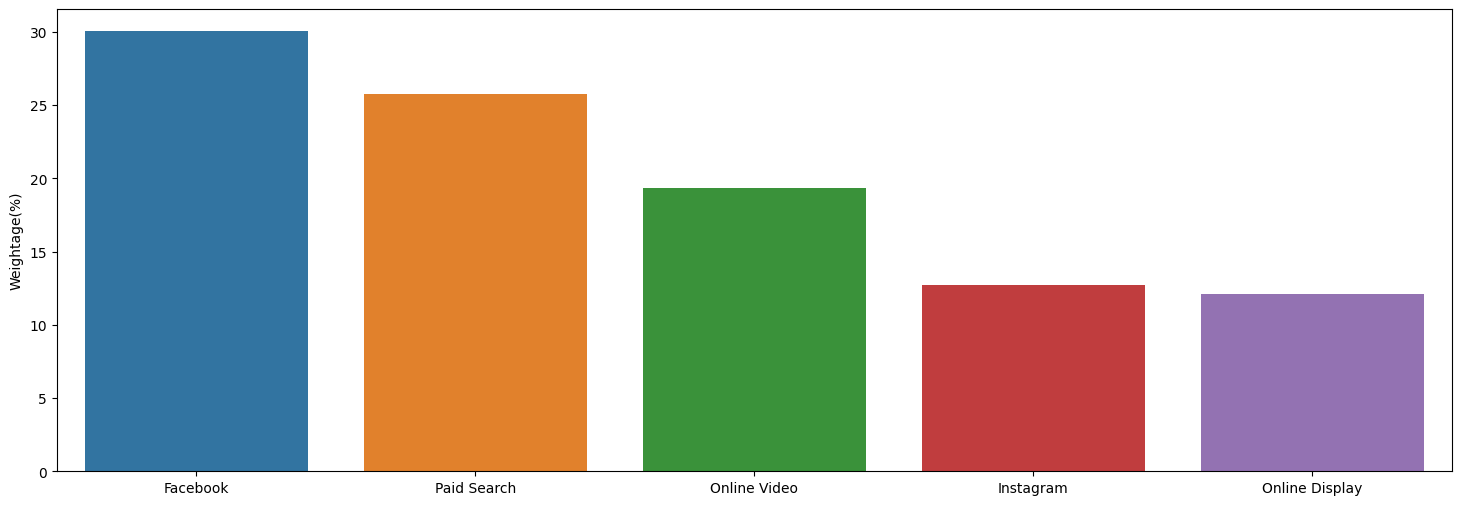

In [39]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot to visualize the weightage of channels
sns.barplot(y='Weightage(%)', x=last_touch.index, data=last_touch)

# Display the plot
plt.show()


## 2. First-Touch Attribution Model

* With a first-touch attribution model, your first marketing interaction receives 100% of the credit.

* If one is mainly focused on widening top of your funnel, this is a useful model. It highlights the channels that first introduced a customer to your brand.

* The problem with this model is that it ignores all subsequent touches, and therefore provides no insight into your down-funnel metrics.

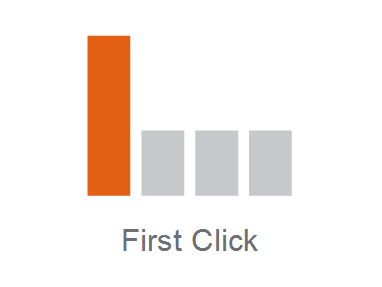

In [40]:
# Here's an image for a better understanding of first-touch attribution model 

im = Image.open(requests.get('https://www.blogindigital.com/wp-content/uploads/2019/08/first-click-attribution-models-common-google-analytics-copy.jpg', stream=True).raw)
im


In [41]:
def first_touch_model(dt, conv_col, channel_col, user_id):
    # Filter rows where conversions are 1
    temp = dt.loc[dt[conv_col] == 1]

    # Create a DataFrame with the first instance for each user
    first_touch = pd.DataFrame(dt.groupby(user_id).first(), index=dt[user_id])

    # Get a list of user IDs from 'temp'
    cookie_index = list(temp[user_id])

    # Locate the user IDs in 'first_touch'
    mid_first_touch = first_touch.loc[cookie_index]

    # Calculate channel weightage as a percentage
    res_first_touch = pd.DataFrame(round(mid_first_touch[channel_col].value_counts(normalize=True) * 100, 2))

    # Rename the column for clarity
    res_first_touch.columns = ['Weightage(%)']

  
    return res_first_touch


In [42]:
first_touch = first_touch_model(data, 'conversion', 'channel', 'cookie')
first_touch

Weightage(%)
Facebook               32.59
Online Video           25.20
Paid Search            18.47
Instagram              14.78
Online Display          8.95

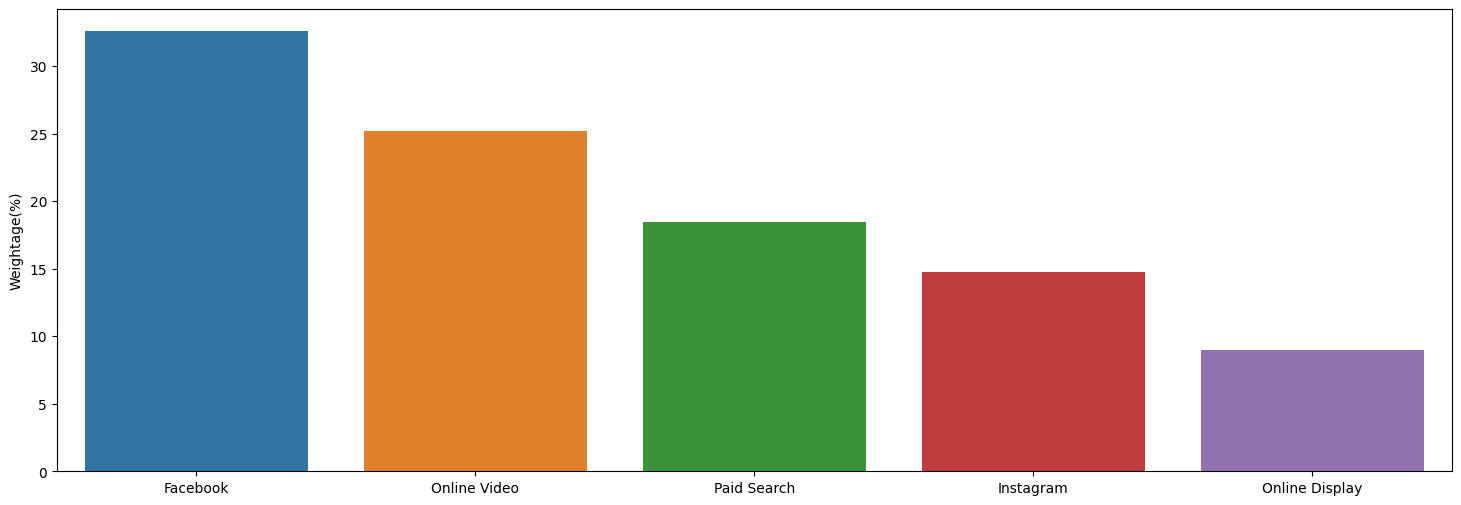

In [43]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=first_touch.index, data=first_touch)

# Display the plot
plt.show()


## 3. Last-Non-direct Touch Attribution Model
* There is one small difference between last non-direct click attribution and last-click attribution. Direct traffic is ignored, and 100% of the credit is assigned to the last channel that the visitor engaged with before making a conversion. To explain this attribution model, we’ll need to change our customer journey slightly.

* This model is best if you want to fully understand the effectiveness of your final marketing activities without direct traffic getting in the way of your analysis. However, this model still doesn’t account for any of the other campaigns or channels the customer interacted with.

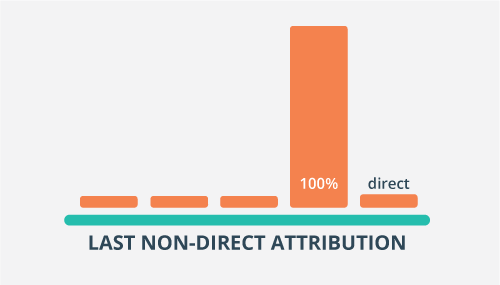

In [44]:
# Here's an image for a better understanding of last-non-direct attribution model 

im = Image.open(requests.get('https://www.blogindigital.com/wp-content/uploads/2019/08/tipmail-grafieken_04__3_last_non_direct_attribution.png', stream=True).raw)
im

In [45]:
def last_non_direct_model(dt, conv_col, channel_col, user_id):
    # Extract the last two observations for each user
    slp = pd.DataFrame(dt.groupby(user_id).tail(2)

    # Filter rows where conversions are 1 from the last two observations
    temp = slp.loc[slp[conv_col] == 1]

    # Create a DataFrame with the first instance for each user from 'slp'
    last_non_direct = pd.DataFrame(slp.groupby(user_id).first(), index=slp[user_id])

    # Get a list of user IDs from 'temp'
    cookie_index = list(temp[user_id])

    # Locate the user IDs in the 'last_non_direct' DataFrame
    mid_last_non_direct = last_non_direct.loc[cookie_index]

    # Calculate channel weightage as a percentage
    res_last_non_direct = pd.DataFrame(round(mid_last_non_direct[channel_col].value_counts(normalize=True) * 100, 2))

    # Rename the column for clarity
    res_last_non_direct.columns = ['Weightage(%)']


    return res_last_non_direct


In [46]:
last_non_direct = last_non_direct_model(data, 'conversion', 'channel', 'cookie')
last_non_direct

Weightage(%)
Facebook               29.97
Paid Search            24.97
Online Video           20.47
Instagram              13.22
Online Display         11.37

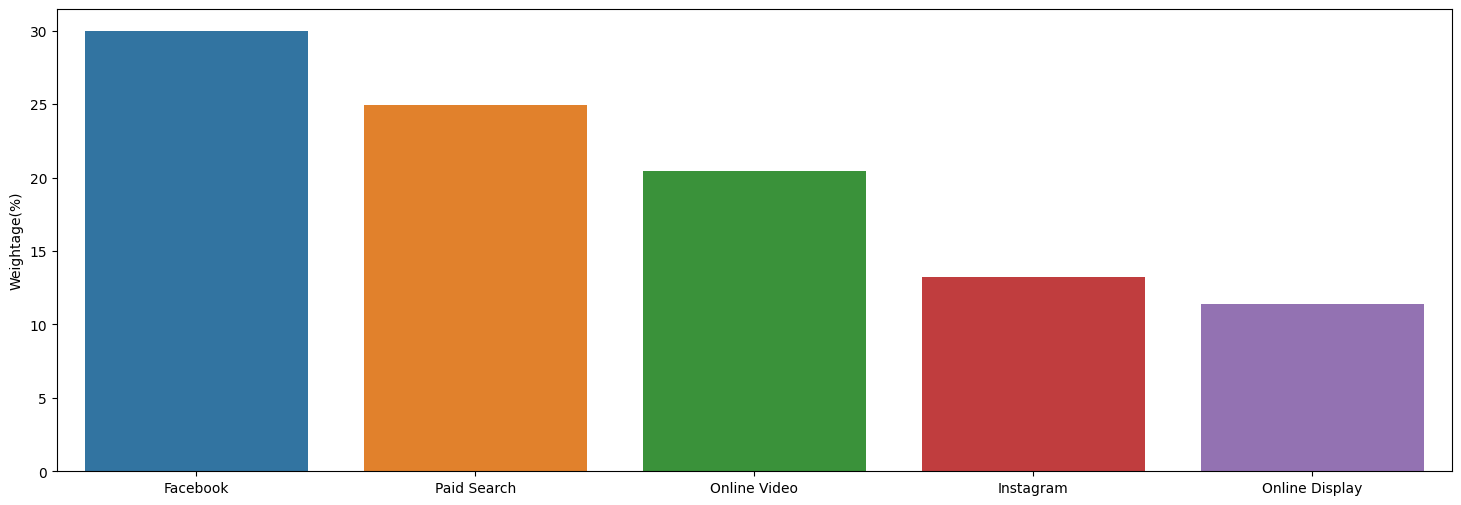

In [47]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=last_non_direct.index, data=last_non_direct)

# Display the plot
plt.show()


---

# II. Multi-Touch Attribution Models

* While single-touch only gives credit to one marketing touchpoint, multi-touch assumes that all touchpoints play some role in driving a conversion. We will look at the most popular multi-touch attribution models which include Linear, Position decay and U-shaped models.

* Multi-touch attribution models have become important for marketers, especially those looking to measure the impact of digital campaigns. This is because they provide a more granular, person-level view than traditional aggregate methods such as media mix modeling.

* These models should be used when the number of channels for a particular campaign is between 5 to 10.(Preferrably Position based i.e., U-shaped Attribution Model)

## 1. Linear Attribution Model

* Linear attribution gives each touchpoint across the buyer journey the same amount of credit toward driving a sale. While this type of attribution considers every touchpoint in the buyer’s journey, it values every touchpoint evenly.

* The advantage of this model is that it is easy to implement and is better than all single-touch attribution models.

* The disadvantage however is that in reality, consumers aren’t equally impacted by every kind of touchpoint/channel. 

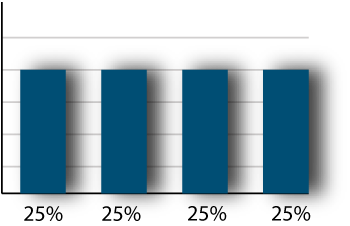

In [48]:
# Here's an image for a better understanding of Linear Attribution Model 

im = Image.open(requests.get('https://www.marketingevolution.com/hs-fs/hubfs/linear%20attribution%20model.png?width=525&name=linear%20attribution%20model.png', stream=True).raw)
im

In [49]:
def linear_model(dt, conv_col, channel_col, user_id):
    # Step 1: Filter data for users who are converted at the end
    pd.options.mode.chained_assignment = None
    temp = dt.loc[dt[conv_col] == 1]
    cookie_index = list(temp[user_id])
    dt['new'] = dt[user_id].isin(cookie_index)
    y = dt['new'].isin([True])
    dt_conv = dt[y]

    # Step 2: Calculate click count for each user
    temp = pd.DataFrame(dt_conv.groupby(user_id).tail(1)
    x = Counter(dt_conv[user_id])
    temp['click_count'] = x.values()

    # Step 3: Add click count to the filtered data
    temp.set_index(user_id, inplace=True)
    count = Counter(dt_conv[user_id])
    dt_conv['clicks'] = dt_conv[user_id].map(count)

    # Step 4: Assign weightages in a linear fashion
    dt_conv = dt_conv.assign(click_per=lambda x: round(100 / dt_conv['clicks'], 2))

    # Step 5: Calculate the mean weightage of each channel
    res_linear = dt_conv.groupby(channel_col, as_index=False)['click_per'].mean()
    total_weight = res_linear['click_per'].sum()
    
    # Step 6: Calculate weightage as a percentage
    res_linear['Weightage(%)'] = res_linear.apply(lambda x: round((x['click_per'] / total_weight) * 100, 2), axis=1)
    res_linear.drop(['click_per'], inplace=True, axis=1)
    res_linear = res_linear.set_index(channel_col)
    res_linear.index.name = None
    return res_linear


In [50]:
linear = linear_model(data, 'conversion', 'channel', 'cookie')    #Calling the linear model function
linear

Weightage(%)
Facebook               16.28
Instagram              16.56
Online Display         26.43
Online Video           13.11
Paid Search            27.63

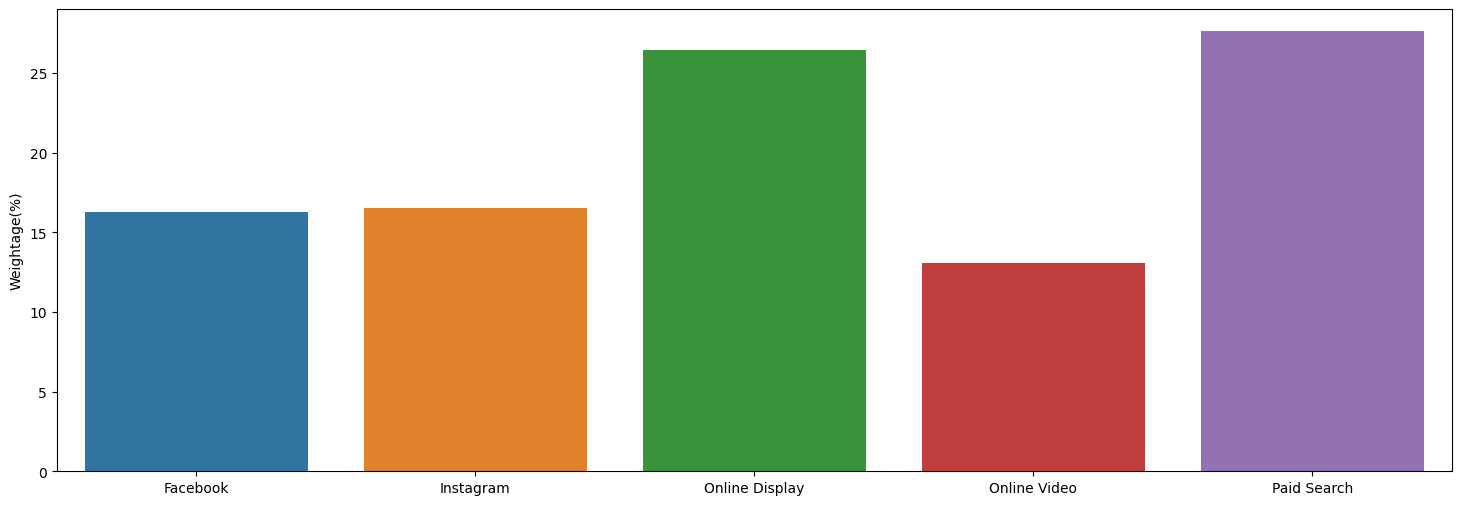

In [51]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=linear.index, data=linear)

# Display the plot
plt.show()


## 2.Position Based (U-shaped) Attribution Model

* The Position-based attribution model (also called U-shaped attribution) splits the credit for a sale between first interaction and the moment it converts.

* 40% of the credit is given to each of these points, with the remaining 20% spread out between any other interactions that happened in the middle.


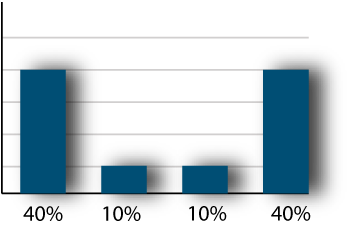

In [52]:
# Here's an image for a better understanding of Position Based (U-shaped) Attribution Model 

im = Image.open(requests.get('https://www.marketingevolution.com/hs-fs/hubfs/U-shaped%20attribution%20model.png?width=525&name=U-shaped%20attribution%20model.png', stream=True).raw)
im

In [53]:
def calc_attribution(click_pos, total_clicks):
    # Assigning weightage according to the position of the channel
    default_att = 0.5  # If a user has visited only 2 channels
    extreme_touch_att_1 = 0.4  # Assigning weightage to the first and last channels
    intermed_att_1 = 0.2  # Total weightage for remaining channels

    if total_clicks == 2:
        return default_att
    elif total_clicks == 1:
        return 1
    else:
        if click_pos == total_clicks or click_pos == 1:
            return extreme_touch_att_1
        else:
            return intermed_att_1 / (total_clicks - 2)  # Giving equal weightage to all the mid channels from the remaining 20%


In [54]:
def u_shaped_model(dt, conv_col, channel_col, user_id):
    # Step 1: Filter data for users who are converted at the end
    pd.options.mode.chained_assignment = None  # Ignore pandas warnings
    temp = dt.loc[dt[conv_col] == 1]
    cookie_index = list(temp[user_id])
    dt['new'] = dt[user_id].isin(cookie_index)
    y = dt['new'].isin([True])
    dt_conv = dt[y]

    # Step 2: Calculate click count for each user and assign click position
    count = Counter(dt_conv[user_id])
    dt_conv['clicks'] = dt_conv[user_id].map(count)
    dt_conv['click_pos'] = dt_conv.groupby(user_id).cumcount() + 1

    # Step 3: Calculate the U-shaped attribution
    dt_Ushaped = dt_conv
    dt_Ushaped['U_Shape'] = dt_conv.apply(lambda val: round(calc_attribution(val.click_pos, val.clicks) * 100, 2), axis=1)

    # Step 4: Calculate the mean weightage of each channel
    res_Ushaped = dt_Ushaped.groupby(channel_col, as_index=False)['U_Shape'].mean()
    total_weight = res_Ushaped['U_Shape'].sum()

    # Step 5: Calculate weightage as a percentage
    res_Ushaped['Weightage(%)'] = res_Ushaped.apply(lambda x: round((x['U_Shape'] / total_weight) * 100, 2), axis=1)
    res_Ushaped.drop(['U_Shape'], inplace=True, axis=1)
    res_Ushaped = res_Ushaped.set_index(channel_col)
    res_Ushaped.index.name = None
    return res_Ushaped


In [55]:
u_shaped = u_shaped_model(data, 'conversion', 'channel', 'cookie')
u_shaped

Weightage(%)
Facebook               16.28
Instagram              16.65
Online Display         26.61
Online Video           12.99
Paid Search            27.48

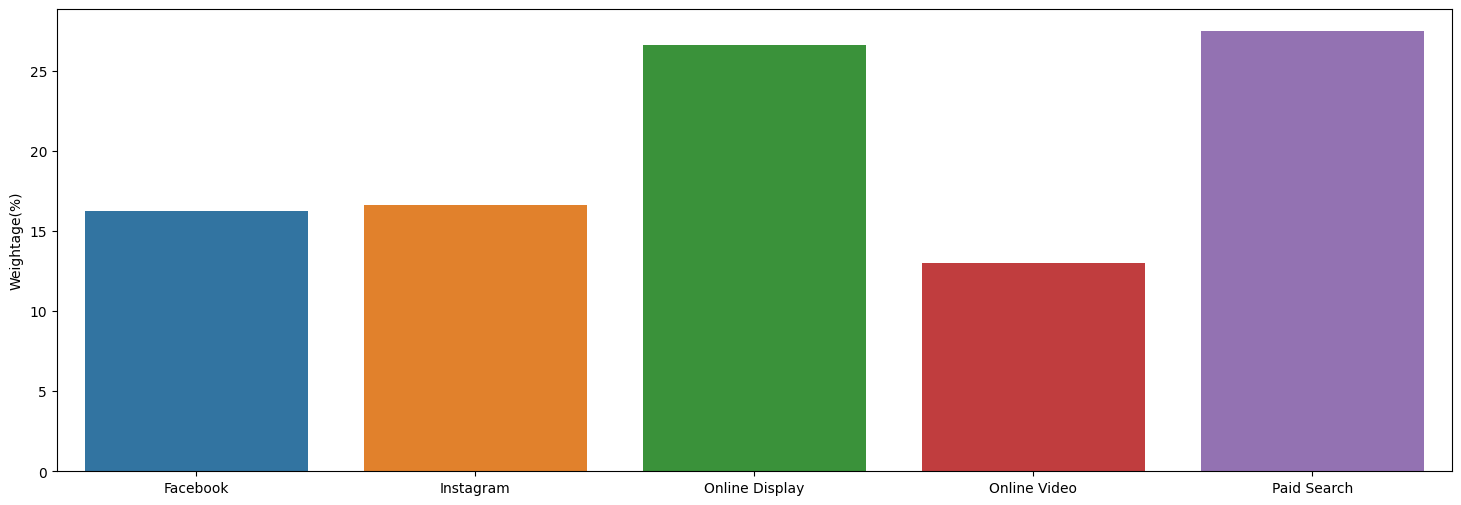

In [56]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=u_shaped.index, data=u_shaped)

# Display the plot
plt.show()


---

## 3. Position Decay Attribution Model

* The Position Decay is a multi-touch attribution model that uses an algorithm which allocates points to all the channels used to convert, giving them credit in reverse order. This model assumes that an user's interest in a product grows with every interaction, and the last one is the most important, as it determines the users to convert. That’s why the highest score is attributed to the last channel; then the score decreases progressively for  every channel until the first one. 

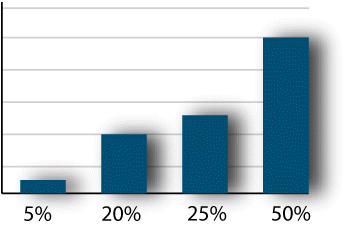

In [57]:
# Here's an image for a better understanding of Position Decay Attribution Model

im = Image.open(requests.get('https://www.marketingevolution.com/hs-fs/hubfs/time%20decay%20attribution%20model.gif?width=525&name=time%20decay%20attribution%20model.gif', stream=True).raw)
im

In [58]:
def calc_attribution(click_pos, total_clicks):
    # Calculate the relative position
    rel_pos = total_clicks - click_pos
    
    # Assign weightage to channels as 2 to the power of the negative relative position
    attribution = pow(2, -(rel_pos))
    
    return attribution


In [59]:
def pos_decay_model(dt, conv_col, channel_col, user_id):
    # Step 1: Filter data for users who are converted at the end
    pd.options.mode.chained_assignment = None
    temp = dt.loc[dt[conv_col] == 1]
    cookie_index = list(temp[user_id])
    dt['new'] = dt[user_id].isin(cookie_index)
    y = dt['new'].isin([True])
    dt_conv = dt[y]

    # Step 2: Calculate click count for each user, assign click position, and calculate PosDecay
    dt_conv['temp'] = 1
    count = Counter(dt_conv[user_id])
    dt_conv['clicks'] = dt_conv[user_id].map(count)
    dt_conv = dt_conv.assign(click_per=lambda x: round(100 / dt_conv['clicks'], 2))
    dt_conv['click_pos'] = dt_conv.groupby(user_id).cumcount() + 1
    dt_conv['PosDecay'] = dt_conv.apply(lambda val: calc_attribution(val.click_pos, val.clicks) * 100, axis=1)
    dt_pos_decay = dt_conv

    # Step 3: Calculate the mean weightage of each channel
    res_pos_decay = dt_pos_decay.groupby(channel_col, as_index=False)['PosDecay'].mean()
    total_weight = res_pos_decay['PosDecay'].sum()

    # Step 4: Calculate weightage as a percentage
    res_pos_decay['Weightage(%)'] = res_pos_decay.apply(lambda x: round((x['PosDecay'] / total_weight) * 100, 2), axis=1)
    res_pos_decay.drop(['PosDecay'], axis=1, inplace=True)
    res_pos_decay = res_pos_decay.set_index(channel_col)
    res_pos_decay.index.name = None
    return res_pos_decay


In [60]:
pos_decay = pos_decay_model(data, 'conversion', 'channel', 'cookie')
pos_decay

Weightage(%)
Facebook               17.10
Instagram              17.14
Online Display         25.44
Online Video           14.68
Paid Search            25.64

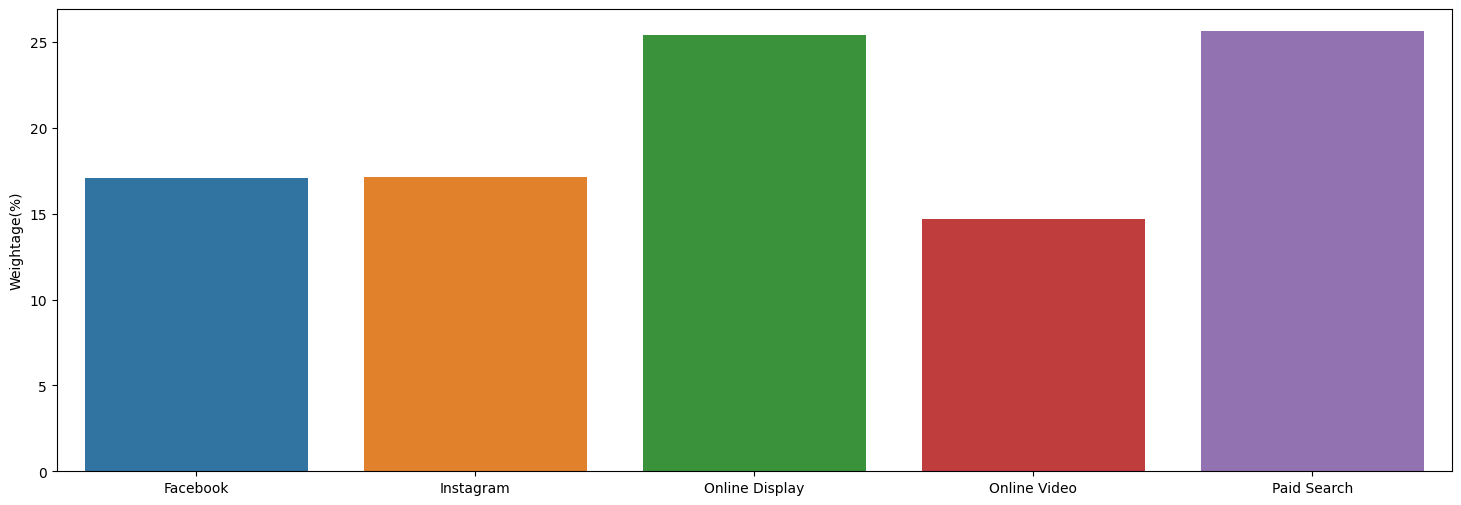

In [61]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=pos_decay.index, data=pos_decay)

# Display the plot
plt.show()


---

# III. Probabilistic Attribution Models

* Probabilistic Attribution uses statistical modeling and machine learning techniques to derive probability of conversion across all marketing touchpoints which can then be used to weight the value of each touchpoint preceding the conversion.

## 1.Markov Attribution Model

* Markov is a probabilistic model that represents buyer journeys as a graph, with the graph’s nodes being the touchpoints or “states”, and the graph’s connecting edges being the observed transitions between those states.

* The key ingredient to the model is the transition probabilities (the likelihood of moving between states). The number of times buyers have transitioned between two states is converted into a probability, and the complete graph can be used to measure the importance of each state and the most likely paths to success.

* Markov Attribution model should be used when the number of channels for a particular campaign is between 10 to 15.

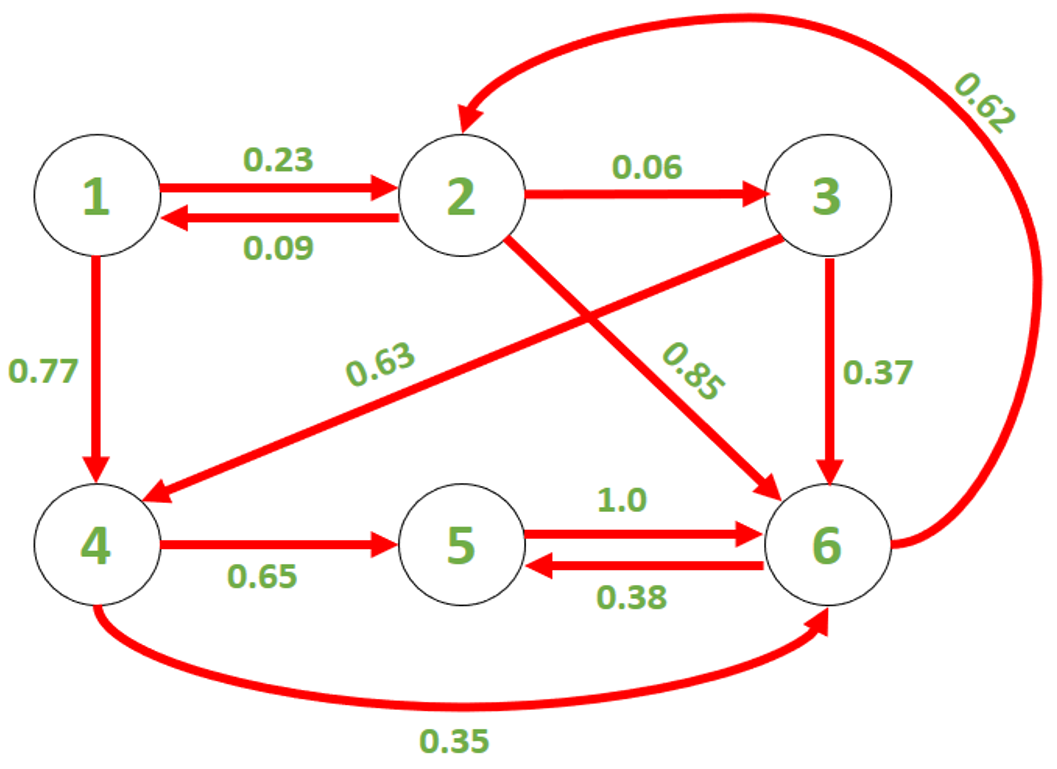

In [62]:
# Here's an image for a better understanding of Markov Attribution Model 

im = Image.open(requests.get('https://media.geeksforgeeks.org/wp-content/uploads/Markov-chain-1.png', stream=True).raw)
im

In [63]:
def transition_states(list_of_paths):
    # Create a set of unique channels from all user paths
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # Create a dictionary to store transition counts for all possible combinations
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    # Count the frequencies for all possible channel transition combinations
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


In [64]:
from collections import defaultdict

def transition_prob(trans_dict, list_of_paths):
    # Create a set of unique channels from all user paths
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # Initialize a defaultdict to store transition probabilities
    trans_prob = defaultdict(dict)

    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]

            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]

            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


In [65]:
import pandas as pd

def transition_matrix(list_of_paths, transition_probabilities):
    # Create an empty transition matrix as a DataFrame
    trans_matrix = pd.DataFrame()
    
    # Create a set of unique channels from all user paths
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # Initialize the transition matrix with zeros
    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    # Fill the transition matrix with transition probabilities
    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


In [66]:
import numpy as np
import pandas as pd

def removal_effects(dt, conversion_rate):
    # Calculate the effect of removing each channel
    removal_effects_dict = {}
    channels = [channel for channel in dt.columns if channel not in ['Start', 'Null', 'Conversion']]
    
    for channel in channels:
        # Create a DataFrame with the channel removed
        removal_dt = dt.drop(channel, axis=1).drop(channel, axis=0)
        
        # Calculate the row sums and null percentages
        for column in removal_dt.columns:
            row_sum = np.sum(list(removal_dt.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_dt.loc[column]['Null'] = null_pct
            removal_dt.loc['Null']['Null'] = 1.0

        # Separate data for conversion and non-conversion
        removal_to_conv = removal_dt[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_dt.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        # Calculate the inverse difference
        removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        
        # Calculate the dot product
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        
        # Calculate the conversion rate
        removal_cvr = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        
        # Calculate the removal effect
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


In [67]:
import numpy as np

def markov_chain_allocations(removal_effects, total_conversions):
    # Calculate the sum of removal effects
    re_sum = np.sum(list(removal_effects.values()))
    
    # Calculate allocations using removal effects and total conversions
    allocations = {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}
    
    return allocations


In [68]:
import pandas as pd
import numpy as np

def markov_model(df, conv_col, channel_col, user_id):
    pd.options.mode.chained_assignment = None

    # Sort the DataFrame by user ID and add visit order
    df = df.sort_values(user_id)
    df['visit_order'] = df.groupby(user_id).cumcount() + 1

    # Group data by user ID, aggregate unique channel sequences, and add last interaction
    df_paths = df.groupby(user_id)[channel_col].aggregate(lambda x: x.unique().tolist()).reset_index()
    df_last_interaction = df.drop_duplicates(user_id, keep='last')[[user_id, conv_col]]
    df_paths = pd.merge(df_paths, df_last_interaction, how='left', on=user_id)

    # Create Start, Conversion, and Null states
    df_paths['start'] = [["Start"] for i in range(len(df_paths[conv_col))]
    df_paths['buff'] = [["Conversion"] for i in range(len(df_paths[conv_col))]
    df_paths['null'] = [["Null"] for i in range(len(df_paths[conv_col))]

    # Create the path based on conversion status
    df_paths['path'] = np.where(df_paths[conv_col] == 0, df_paths['start'] + df_paths[channel_col] + df_paths['null'], df_paths['start'] + df_paths[channel_col] + df_paths['buff'])
    df_paths = df_paths[[user_id, 'path']]

    list_of_paths = df_paths['path']
    total_conversions = np.sum(a.count('Conversion') for a in df_paths['path'].tolist())
    base_conversion_rate = total_conversions / len(list_of_paths)

    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix = transition_matrix(list_of_paths, trans_prob)
    removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

    attributions = markov_chain_allocations(removal_effects_dict, total_conversions)
    res_markov = pd.DataFrame(attributions.values(), index=attributions.keys())
    res_markov.columns = ['weightage']
    sum = res_markov['weightage'].sum()
    res_markov['Weightage(%)'] = res_markov.apply(lambda x: round((x['weightage'] / sum) * 100, 2), axis=1)
    res_markov.drop(['weightage'], axis=1, inplace=True)
    res_markov = res_markov.sort_index()
    
    return res_markov


In [ ]:
markov = markov_model(data, 'conversion', 'channel', 'cookie')
markov

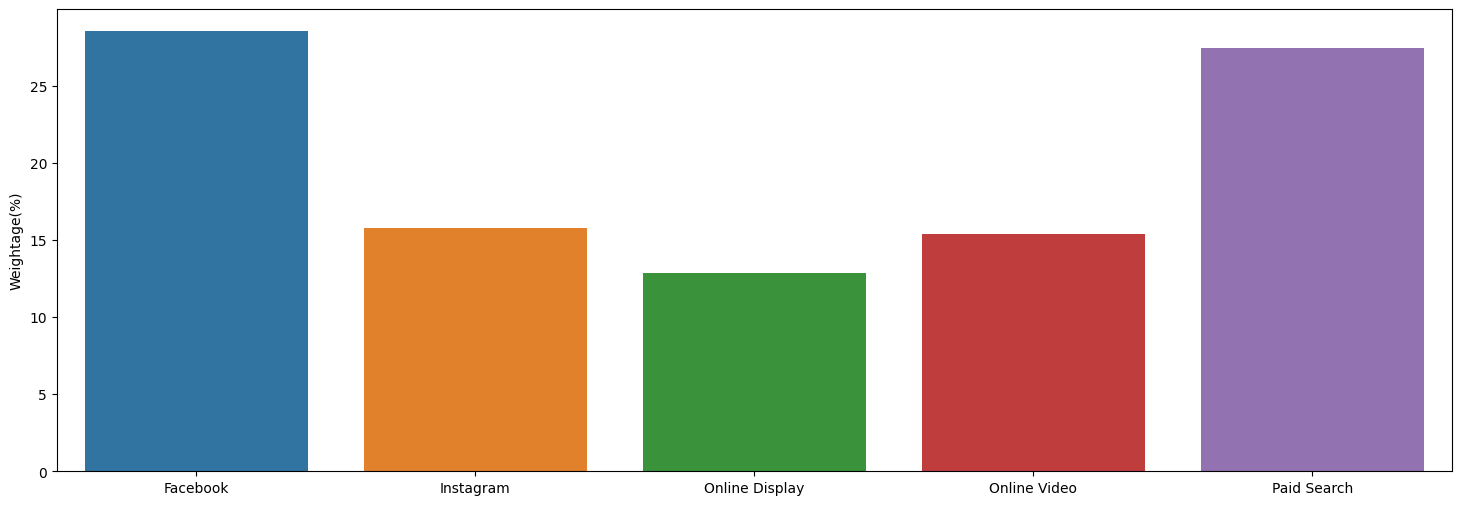

In [70]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=markov.index, data=markov)

# Display the plot
plt.show()


## 2.Shapley Value Model

* Shapley value provide a stable way to measure channel influence and fairly divide the credit for sales conversions between the channels, based on their individual contribution to the total payoff.

* As businesses strive for more accountability, efficiency, and data-driven decision making, cooperative game theory and the Shapley value provide marketing departments with an accurate and tailored solution for attribution that has the potential to deliver much more than the rules-based models are able to provide.

* Shapley Attribution model should be used when the number of channels for a particular campaign is 15 or more.

In [71]:
import itertools

def power_set(List):
    # Create a power set of a given list
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i + 1)]
    return PS


In [72]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''

    if len(s) == 1:
        return s
    else:
        sub_channels = []
        for i in range(1, len(s) + 1):
            sub_channels.extend(map(list, itertools.combinations(s, i)))
    return list(map(",".join, map(sorted, sub_channels)))


In [73]:
def v_function(A, C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionary containing the number of conversions that each subset of channels has yielded.
    '''

    subsets_of_A = subsets(A)
    worth_of_A = 0

    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]

    return worth_of_A


In [74]:
def factorial(n):
    # Calculate the factorial of a non-negative integer n
    if n == 0:
        return 1
    else:
        return n * factorial(n - 1)


In [75]:
def calculate_shapley(df, col_name):
    '''
    This function returns the Shapley values.
    Inputs:
    - df: A dataframe with two columns: ['channels_subset', 'conversion_sum'].
    - col_name: A string representing the name of the column with conversions in the dataframe.
    
    Note:
    - Make sure that each value in channel_subset is in alphabetical order. For example, "Facebook,Paid Search" and "Paid Search,Facebook" should be considered the same.
    - Be careful with the distinct number of channels as it can significantly affect the performance of this function.
    '''
    
    # Create a dictionary with conversion values
    c_values = df.set_index("channels_subset").to_dict()[col_name]
    
    # Extract unique single channels
    df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())
    
    # Initialize a dictionary for v values
    v_values = {}
    
    # Calculate v values for all channel subsets
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A, c_values)
    
    # Get the number of channels
    n = len(channels)
    
    # Initialize a defaultdict for Shapley values
    shapley_values = defaultdict(int)
    
    # Calculate Shapley values
    for channel in channels:
        for A in v_values.keys():
            if channel not in A.split(","):
                cardinal_A = len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)
                A_with_channel = ",".join(sorted(A_with_channel))
                
                # Calculate weight
                weight = (factorial(cardinal_A) * factorial(n - cardinal_A - 1) / factorial(n))
                
                # Calculate marginal contribution
                contrib = (v_values[A_with_channel] - v_values[A])
                
                shapley_values[channel] += weight * contrib
        
        # Add the term corresponding to the empty set
        shapley_values[channel] += v_values[channel] / n
        
    return shapley_values


In [76]:
from collections import Counter

def shapley_model(df, conv_col, channel_col, user_id):
    # Group user paths by user ID and aggregate unique channels
    dt_paths = df.sort_values(channel_col).groupby(user_id)[channel_col].aggregate(lambda x: x.unique().tolist()).reset_index()
    dt_paths['channels'] = [str(x) for x in dt_paths[channel_col]

    # Count the occurrences of each channel subset
    channel_count = Counter(dt_paths['channels'])
    channel_ct = pd.DataFrame(channel_count.items())
    channel_ct[0] = channel_ct[0].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", "").replace(", ", ","))

    channel_ct.columns = ['channels_subset', 'conversion_sum']

    # Calculate Shapley values
    attribution = calculate_shapley(channel_ct, 'conversion_sum')
    res_shapley = pd.DataFrame(attribution.values(), index=attribution.keys())
    res_shapley.columns = ['weightage']
    
    # Normalize and sort the results
    total_weightage = res_shapley['weightage'].sum()
    res_shapley['Weightage(%)'] = res_shapley.apply(lambda x: round((x['weightage'] / total_weightage) * 100, 2), axis=1)
    res_shapley.drop(['weightage'], axis=1, inplace=True)
    res_shapley = res_shapley.sort_index()
    
    return res_shapley


In [77]:
shapley=shapley_model(data, 'conversion', 'channel', 'cookie')
shapley

Weightage(%)
Facebook               27.29
Instagram              13.11
Online Display         14.26
Online Video           14.27
Paid Search            31.06

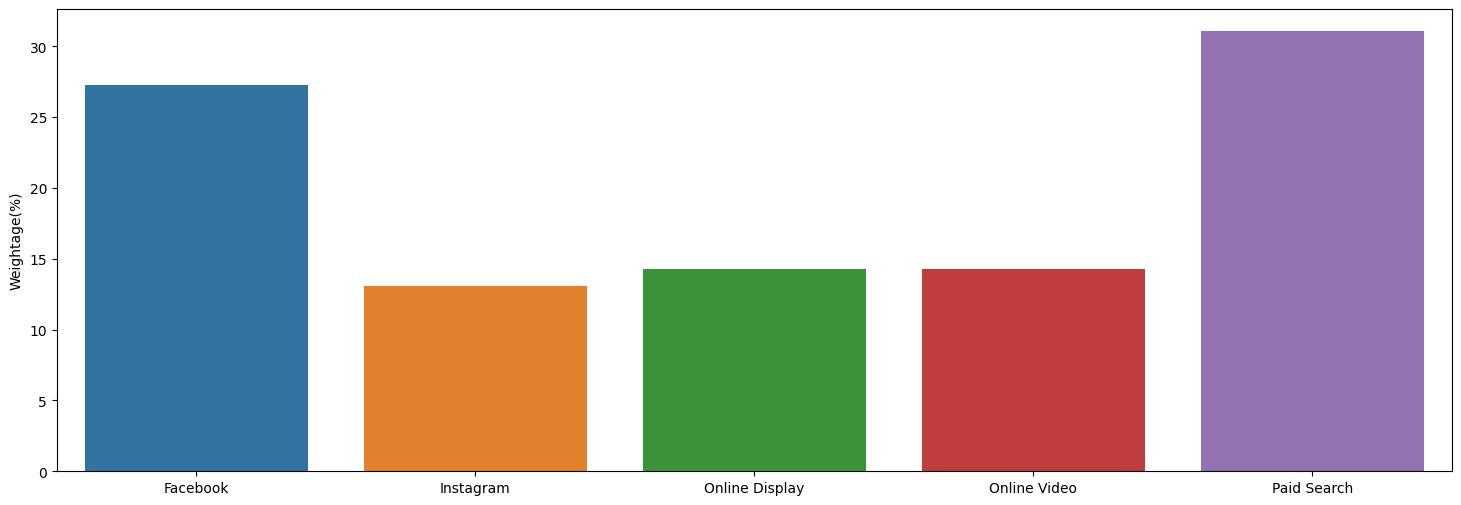

In [78]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=shapley.index, data=shapley)

# Display the plot
plt.show()


---

# RESULTS

## Tables

In [79]:
# Combine the results from different attribution models into a single DataFrame
Combined_dataframe = pd.concat([last_touch, first_touch, last_non_direct, linear, u_shaped, pos_decay, markov, shapley], axis=1)

# Set column names for the DataFrame
Combined_dataframe.columns = ['Last-Touch', 'First-Touch', 'Last-Non-direct', 'Linear', 'U-shaped', 'Position Decay', 'Markov', 'Shapley']

# Calculate the mean attribution for each channel and round to two decimal places
Combined_dataframe['Mean'] = round(Combined_dataframe.mean(axis=1), 2)

# Display the Combined_dataframe
Combined_dataframe


Last-Touch  First-Touch  Last-Non-direct  Linear  U-shaped  \
Facebook             30.05        32.59            29.97   16.28     16.28   
Paid Search          25.78        18.47            24.97   27.63     27.48   
Online Video         19.32        25.20            20.47   13.11     12.99   
Instagram            12.72        14.78            13.22   16.56     16.65   
Online Display       12.13         8.95            11.37   26.43     26.61   

                Position Decay  Markov  Shapley   Mean  
Facebook                 17.10   28.55    27.29  24.76  
Paid Search              25.64   27.46    31.06  26.06  
Online Video             14.68   15.38    14.27  16.93  
Instagram                17.14   15.76    13.11  14.99  
Online Display           25.44   12.85    14.26  17.26

## Graphs

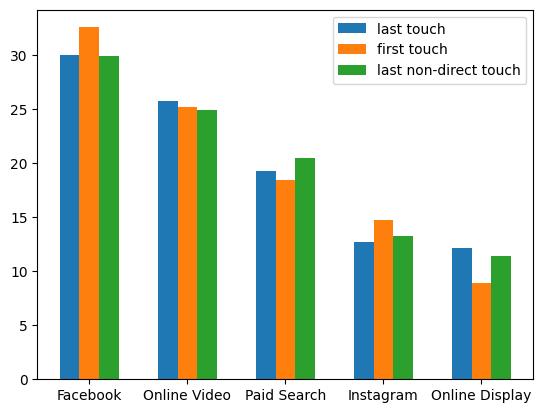

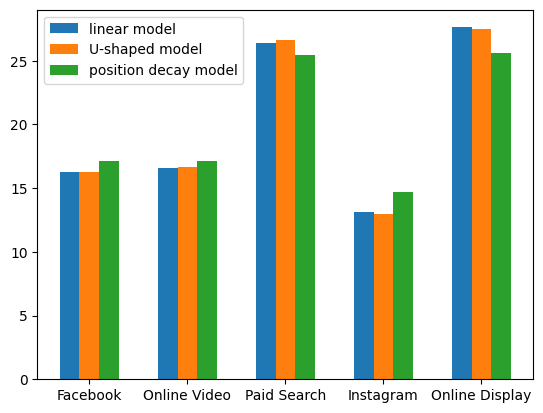

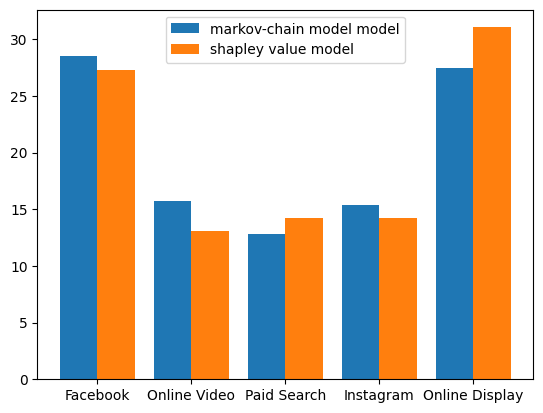

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Create the first set of bar plots for Last-Touch, First-Touch, and Last Non-Direct Touch models
X_axis = np.arange(len(first_touch.index))
plt.bar(X_axis - 0.2, last_touch['Weightage(%)'], 0.2, label='Last Touch')
plt.bar(X_axis, first_touch['Weightage(%)'], 0.2, label='First Touch')
plt.bar(X_axis + 0.2, last_non_direct['Weightage(%)'], 0.2, label='Last Non-Direct Touch')
plt.xticks(X_axis, first_touch.index)
plt.legend()
plt.title('Comparison of Attribution Models: Last Touch, First Touch, Last Non-Direct Touch')
plt.show()

print()

# Create the second set of bar plots for Linear, U-Shaped, and Position Decay models
X_axis = np.arange(len(first_touch.index))
plt.bar(X_axis - 0.2, linear['Weightage(%)'], 0.2, label='Linear Model')
plt.bar(X_axis, u_shaped['Weightage(%)'], 0.2, label='U-Shaped Model')
plt.bar(X_axis + 0.2, pos_decay['Weightage(%)'], 0.2, label='Position Decay Model')
plt.xticks(X_axis, first_touch.index)
plt.legend()
plt.title('Comparison of Attribution Models: Linear, U-Shaped, Position Decay')
plt.show()

print()

# Create the third set of bar plots for Markov Chain and Shapley Value models
X_axis = np.arange(len(markov.index))
plt.bar(X_axis - 0.2, markov['Weightage(%)'], 0.4, label='Markov Chain Model')
plt.bar(X_axis + 0.2, shapley['Weightage(%)'], 0.4, label='Shapley Value Model')
plt.xticks(X_axis, first_touch.index)
plt.legend()
plt.title('Comparison of Attribution Models: Markov Chain and Shapley Value')
plt.show()


---

# Budget Optimization

In [87]:
from gekko import GEKKO

# Create a GEKKO model
m = GEKKO()

# Number of channels
n = 5

# Input budget for the campaign
budget = int(input("Enter campaign budget: "))
print("Budget of the campaign:", budget)

# Get mean attribution values for each channel
coeff_A = Combined_dataframe['Mean'].tolist()

# Get channel names
ch_names = list(sorted(Combined_dataframe.index))

# Assign lower and upper bounds to each channel's budget allocation variable
x1 = m.Var(lb=100, ub=budget)
x2 = m.Var(lb=100, ub=budget)
x3 = m.Var(lb=100, ub=budget)
x4 = m.Var(lb=100, ub=budget)
x5 = m.Var(lb=100, ub=budget)

# Take input of upper bounds on spending for each channel
for j in range(n):
    print("Channel", j+1, "should not exceed: ", end='\n')
    z = int(input())
    print(z)
    m.Equation(globals()["x" + str(j+1)] <= z)

# Ensure the total budget is not exceeded
m.Equation(x1 + x2 + x3 + x4 + x5 <= budget)

# Maximize the objective function using mean attributions
m.Maximize(coeff_A[0]*x1 + coeff_A[1]*x2 + coeff_A[2]*x3 + coeff_A[3]*x4 + coeff_A[4]*x5)

# Solve the optimization problem
m.solve(disp=False)

# Get the optimized budget allocation for each channel
p1 = x1.value[0]
p2 = x2.value[0]
p3 = x3.value[0]
p4 = x4.value[0]
p5 = x5.value[0]

# Print the budget allocation for each channel
print('\nBudgets:\n')
print(ch_names[0] + ": " + str(round(p1, 0)))
print(ch_names[1] + ": " + str(round(p2, 0)))
print(ch_names[2] + ": " + str(round(p3, 0)))
print(ch_names[3] + ": " + str(round(p4, 0)))
print(ch_names[4] + ": " + str(round(p5, 0)))


Budget of the campaign: 1000


Channel 1 should not exceed : 
100
Channel 2 should not exceed : 
200
Channel 3 should not exceed : 
3300
Channel 4 should not exceed : 
400
Channel 5 should not exceed : 
300


Budgets:


Facebook: 100.0
Instagram: 200.0
Online Display: 300.0
Online Video: 100.0
Paid Search: 300.0


---